In [1]:
# Проект Дашборд конверсий

In [2]:
## Загрузка библиотек

In [97]:
import os
import pandas as pd
import requests as req
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dotenv import load_dotenv

load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

resp = req.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
resp_visits = req.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})

In [98]:
## Чтение и выборка зарегистрированных и посещаемых пользователей

In [99]:
visitors = pd.DataFrame(resp_visits.json())
regs = pd.DataFrame(resp.json())
visitors['datetime'] = pd.to_datetime(visitors['datetime']).dt.date
regs['datetime'] = pd.to_datetime(regs['datetime']).dt.date

In [100]:
regs.head()

,datetime,user_id,email,platform,registration_type
0,2023-03-01,2e0f6bb8-b029-4f45-a786-2b53990d37f1,ebyrd@example.org,web,google
1,2023-03-01,f007f97c-9d8b-48b5-af08-119bb8f6d9b6,knightgerald@example.org,web,email
2,2023-03-01,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15,cherylthompson@example.com,web,apple
3,2023-03-01,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email
4,2023-03-01,27f875fc-f8ce-4aeb-8722-0ecb283d0760,denise86@example.net,web,google


In [101]:
visitors.head(100)

,visit_id,platform,user_agent,datetime
0,1de9ea66-70d3-4a1f-8735-df5ef7697fb9,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
1,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,2023-03-01
2,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,2023-03-01
3,19322fed-157c-49c6-b16e-2d5cabeb9592,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-03-01
4,04762a22-3c9f-40c9-9ac9-6628c4381836,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
...,...,...,...,...
95,79cf0607-cb47-4aac-b811-84f95ddbb589,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
96,e363bad9-23d8-4263-aa84-727e10b07891,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
97,54ef7f95-9688-4018-a535-7be9e7c5af18,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
98,c0c16b36-c0ea-42d1-9950-a263faec571d,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01


In [102]:
## Анализ зарегистрированных пользователей

In [103]:
visitors.describe()

,visit_id,platform,user_agent,datetime
count,91997,91997,91997,91997
unique,51795,4,32,61
top,dcd260f9-4923-4fac-8d4b-05aa7315f752,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-08
freq,4,82492,4833,2624


In [104]:
## Анализ посещаемых пользователей

In [105]:
regs.describe()

,datetime,user_id,email,platform,registration_type
count,8179,8179,8179,8179,8179
unique,61,8179,8023,3,4
top,2023-03-06,b07ef5d6-d153-43dd-a001-c8dfae97e856,csmith@example.org,android,email
freq,230,1,4,3895,3362


In [106]:
## Регистрация уникальных пользователей

In [107]:
visitors = visitors.drop_duplicates(subset="visit_id", keep="last")
visitors = visitors[~visitors['platform'].isin(['bot'])]

In [108]:
## Группировка пользователей

In [109]:
grouped_regs = regs.groupby(['platform', 'datetime'])['datetime'].count().reset_index(name='registrations')

In [110]:
grouped_regs.head()

,platform,datetime,registrations
0,android,2023-03-01,61
1,android,2023-03-02,59
2,android,2023-03-03,22
3,android,2023-03-04,77
4,android,2023-03-05,54


In [111]:
grouped_visitors = visitors.groupby(['platform', 'datetime'])['datetime'].count().reset_index(name='visits')

In [112]:
grouped_visitors.head(100)

,platform,datetime,visits
0,android,2023-03-01,75
1,android,2023-03-02,67
2,android,2023-03-03,26
3,android,2023-03-04,94
4,android,2023-03-05,66
...,...,...,...
95,ios,2023-04-04,33
96,ios,2023-04-05,28
97,ios,2023-04-06,24
98,ios,2023-04-07,56


In [113]:
## Соединение таблиц и расчет конверсии

In [114]:
conversion = pd.merge(
    grouped_visitors, grouped_regs
)
conversion = conversion.rename(columns={'datetime': 'date_group'})
conversion['conversion'] = (conversion['registrations'] / conversion['visits']) * 100
conversion.sort_values(by='date_group', inplace=True)
conversion.to_json('./conversion.json')

In [115]:
conversion.head()

,platform,date_group,visits,registrations,conversion
0,android,2023-03-01,75,61,81.333333
61,ios,2023-03-01,22,18,81.818182
122,web,2023-03-01,787,8,1.016518
1,android,2023-03-02,67,59,88.059701
62,ios,2023-03-02,31,24,77.419355


In [116]:
## Группируем и аггрегируем столбцы по дате

In [117]:
grouped_conversion = conversion.groupby('date_group', as_index=False).sum()
grouped_conversion.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,androidiosweb,884,87,164.168034
1,2023-03-02,androidiosweb,1050,106,167.895023
2,2023-03-03,androidiosweb,1147,107,174.333238
3,2023-03-04,androidiosweb,1232,159,148.795048
4,2023-03-05,ioswebandroid,1145,115,167.583704


In [118]:
## Загружаем данные по рекламным компаниями

In [119]:
ads = pd.read_csv('./ads.csv')
ads['date'] = pd.to_datetime(ads['date']).dt.date

In [120]:
group_ads.head()

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,advanced_algorithms_series,212
1,2023-03-02,google,cpc,advanced_algorithms_series,252
2,2023-03-03,google,cpc,advanced_algorithms_series,202
3,2023-03-04,google,cpc,advanced_algorithms_series,223
4,2023-03-05,google,cpc,advanced_algorithms_series,265
...,...,...,...,...,...
154,2023-09-13,vk,social,intro_to_python_course,277
155,2023-09-14,vk,social,intro_to_python_course,221
156,2023-09-15,vk,social,intro_to_python_course,175
157,2023-09-16,vk,social,intro_to_python_course,224


In [121]:
## Группируем рекламу по дате и объединяем с конверсией

In [122]:
ads = ads.fillna({'utm_campaign': 'none', 'cost': 0})
conversion_ads = pd.merge(
    grouped_conversion, ads, left_on='date_group', right_on='date'
)
conversion_ads.sort_values(by='date_group', inplace=True)
conversion_ads.head()
grouped_ads_conversion = conversion_ads.groupby('date_group')
grouped_ads_conversion.head()
conversion_ads = conversion_ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
conversion_ads.to_json('./ads.json')
conversion_ads.head()

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,884,87,212,advanced_algorithms_series
1,2023-03-02,1050,106,252,advanced_algorithms_series
2,2023-03-03,1147,107,202,advanced_algorithms_series
3,2023-03-04,1232,159,223,advanced_algorithms_series
4,2023-03-05,1145,115,265,advanced_algorithms_series


In [123]:
## Визуализируем данные на графиках с помощью matplotlib.pyplot, seaborn, plotly

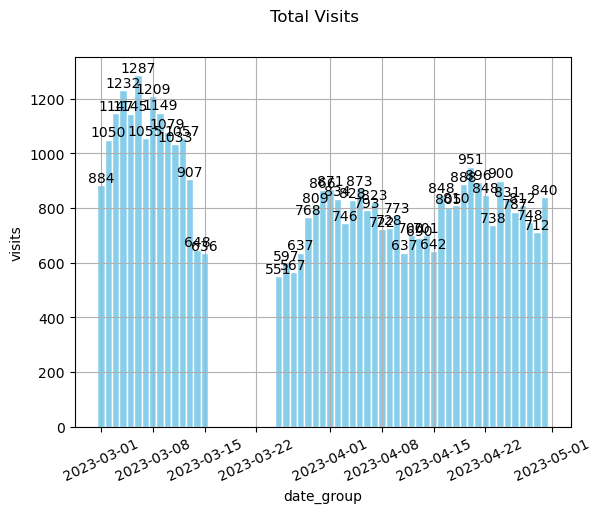

<Figure size 640x480 with 0 Axes>

In [126]:
# sns.barplot(x="date_group", y="visits", data=conversion_ads, color='skyblue')

fig, ax = plt.subplots()
fig.suptitle("Total Visits")
# fig.set_size_inches((10, 10))
bars = ax.bar(conversion_ads['date_group'],
       conversion_ads['visits'],
       width=1,
       color='skyblue',
       edgecolor="white"
      )
plt.xlabel("date_group")
plt.ylabel('visits')
plt.xticks(rotation = 25)
ax.grid()
ax.bar_label(bars)
plt.show()
plt.savefig('./charts/visitors_by_platform.png')

<Axes: xlabel='date_group', ylabel='visits'>

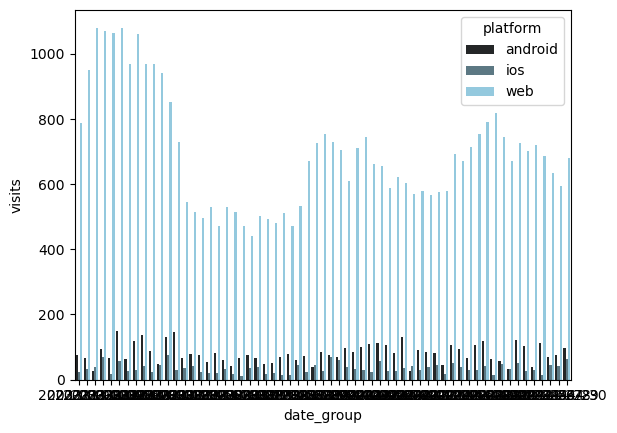

In [125]:
sns.barplot(x="date_group", y="visits", hue='platform', data=conversion, palette='dark:skyblue')